In [1]:
import pandas as pd
import numpy as np
import requests
import json
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
import folium


Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.12.5          |   py36h5fab9bb_1         143 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.1.0                |     pyhd3deb0d_0          64 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         240 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.1.0-pyhd3deb0d_0

The following packages will be UPDATED:

  certifi                          2020.12.5-py36h5fab9bb_0 --> 2020.12.5-py36h5fab9bb_1



geopy-2.1.0          | 64 KB     

In [2]:
#Read Taipei geo location data
tpe_geo = pd.read_csv('taipei_geo_location.csv')
tpe_geo.head()

,District,City,District (Chinese),Latitude,Longitude
0,Zhongzheng,Taipei City,中正區,25.032400,121.518000
1,Datong,Taipei City,大同區,25.065986,121.515514
2,Zhongshan,Taipei City,中山區,25.064361,121.533468
3,Songshan,Taipei City,松山區,25.049698,121.577206
4,Daan,Taipei City,大安區,25.026389,121.534444


In [3]:
CLIENT_ID = 'HB4OBLN4Z5HQ02S2SVODAT4VPKMJTBE0F4RT2VBDLSY0DRSR' # your Foursquare ID
CLIENT_SECRET = 'ULLR4G5LZZUOPC2XUNQTO4OSJ4HLBSRYLUQWAJ42DWYGIVNY' # your Foursquare Secret
VERSION = '20210120' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: HB4OBLN4Z5HQ02S2SVODAT4VPKMJTBE0F4RT2VBDLSY0DRSR
CLIENT_SECRET:ULLR4G5LZZUOPC2XUNQTO4OSJ4HLBSRYLUQWAJ42DWYGIVNY


In [29]:
#Explore all venues in Taipei
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [30]:
taipei_venues = getNearbyVenues(names=tpe_geo['District'],
                                   latitudes=tpe_geo['Latitude'],
                                   longitudes=tpe_geo['Longitude'])

Zhongzheng
Datong
Zhongshan
Songshan
Daan
Wanhua
Xinyi
Shilin
Beitou
Neihu
Nangang
Wenshan
Wanli
Jinshan
Banqiao
Xizhi
Shenkeng
Shiding
Ruifang
Pingxi
Shuangxi 
Gongliao
Xindian
Pinglin
Wulai
Yonghe
Zhonghe
Tucheng
Sanxia
Shulin
Yingge
Sanchong
Xinzhuang
Taishan
Linkou
Luzhou
Wugu
Bali
Tamsui 
Sanzhi
Shihmen


In [31]:
print(taipei_venues.shape)
taipei_venues.head()

(565, 7)


,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Zhongzheng,25.0324,121.518,Kinfen Braised Pork Rice (金峰魯肉飯),25.032194,121.518534,Taiwanese Restaurant
1,Zhongzheng,25.0324,121.518,虎記商行,25.031744,121.519284,Café
2,Zhongzheng,25.0324,121.518,樂田麵包屋 Gakuden Boulangerie,25.032757,121.517534,Bakery
3,Zhongzheng,25.0324,121.518,National Theater (國家戲劇院),25.035197,121.518188,Theater
4,Zhongzheng,25.0324,121.518,豆味行甜不辣、豆花、芋圓,25.031303,121.517232,Snack Place


In [7]:
# Methodology (EDA)
print(len(taipei_venues['District'].unique()))
pd.DataFrame(taipei_venues['District'].value_counts()).head()

39


,District
Shilin,62
Xinyi,57
Tamsui,42
Banqiao,34
Zhongzheng,31


In [8]:
top3_district = taipei_venues[taipei_venues['District'].isin(['Shilin','Xinyi','Tamsui '])]
top3_summary = top3_district.groupby(['District','Venue Category'])['Venue'].count().reset_index()
top3_sorted = top3_summary.sort_values(by=['District','Venue'],ascending=False)
top3_sorted.groupby(['District']).head(3)

,District,Venue Category,Venue
73,Xinyi,Department Store,5
76,Xinyi,Electronics Store,3
85,Xinyi,Lounge,3
62,Tamsui,Taiwanese Restaurant,7
39,Tamsui,Bakery,3
43,Tamsui,Chinese Restaurant,3
5,Shilin,Café,7
3,Shilin,Breakfast Spot,3
4,Shilin,Bubble Tea Shop,3


In [9]:
taipei_summary = taipei_venues.groupby(['District','Venue Category'])['Venue'].count().reset_index()
taipei_summary_sorted = taipei_summary.sort_values(by=['District','Venue'],ascending=False)
taipei_summary_sorted.groupby(['District']).head(1).sort_values(by=['Venue'],ascending=False)

,District,Venue Category,Venue
152,Shilin,Café,7
242,Tamsui,Taiwanese Restaurant,7
45,Daan,Café,5
303,Xinyi,Department Store,5
392,Zhongzheng,Café,4
65,Datong,Taiwanese Restaurant,4
127,Sanxia,Dessert Shop,4
196,Songshan,Convenience Store,4
121,Sanchong,Convenience Store,4
13,Banqiao,Hotel,4


In [10]:
# create dummy indicator for venue category to be used later
taipei_cat = pd.get_dummies(taipei_venues[['Venue Category']], prefix="", prefix_sep="")

# add district column back to dataframe
taipei_cat['District'] = taipei_venues['District'] 

# move district column to the first column
fixed_columns = [taipei_cat.columns[-1]] + list(taipei_cat.columns[:-1])
taipei_cat = taipei_cat[fixed_columns]

taipei_cat.head()

,District,American Restaurant,Arcade,Art Museum,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Beer Bar,...,Thai Restaurant,Theater,Tourist Information Center,Toy / Game Store,Trail,Train Station,Tunnel,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park
0,Zhongzheng,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Zhongzheng,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Zhongzheng,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Zhongzheng,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,Zhongzheng,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# calculate percentage 
taipei_dist_summary = taipei_cat.groupby('District').mean().reset_index()
taipei_dist_summary.head()

,District,American Restaurant,Arcade,Art Museum,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Beer Bar,...,Thai Restaurant,Theater,Tourist Information Center,Toy / Game Store,Trail,Train Station,Tunnel,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park
0,Bali,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
1,Banqiao,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.029412,0.000000,0.0
2,Beitou,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
3,Daan,0.0,0.0,0.0,0.000000,0.0,0.052632,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.052632,0.0
4,Datong,0.0,0.0,0.0,0.052632,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


In [82]:
# Find out top 5
num_top_venues = 5

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['District'] = taipei_dist_summary['District']

for ind in np.arange(taipei_dist_summary.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(taipei_dist_summary.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()


,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Bali,Italian Restaurant,Noodle House,Convenience Store,Electronics Store,Food & Drink Shop
1,Banqiao,Hotel,Café,Chinese Restaurant,Fast Food Restaurant,Convenience Store
2,Beitou,Tea Room,Chinese Restaurant,Italian Restaurant,Dessert Shop,Hot Spring
3,Daan,Café,Convenience Store,Tea Room,Coffee Shop,Vietnamese Restaurant
4,Datong,Taiwanese Restaurant,Café,Coffee Shop,Convenience Store,Night Market


#### Cluster District
##### Run K-Means clustering to segment the districts
###### Run a list of K to find out the optimal cluster to choose

In [25]:
!conda install -c conda-forge kneed --yes
import matplotlib.pyplot as plt
import kneed
%matplotlib inline

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - kneed


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    joblib-1.0.0               |     pyhd8ed1ab_0         206 KB  conda-forge
    kneed-0.7.0                |     pyh9f0ad1d_0          12 KB  conda-forge
    scikit-learn-0.24.1        |   py36he4fde30_0         7.5 MB  conda-forge
    scipy-1.5.3                |   py36h9e8f40b_0        19.1 MB  conda-forge
    threadpoolctl-2.1.0        |     pyh5ca1d4c_0          15 KB  conda-forge
    ------------------------------------------------------------
                                           Total:        26.8 MB

The following NEW packages will be INSTALLED:

  joblib             conda-forge/noarch::joblib-1.0.0-pyhd8ed1ab_0
  kneed              conda-forge/noarch::kneed-0.7.0-pyh9f0ad1d_0
  scikit-

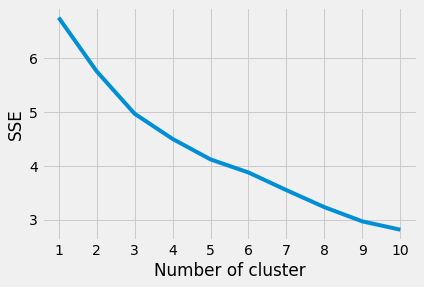

In [22]:
#Use elbow method to find out optimal k
sse = []

for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(taipei_clustering)
    sse.append(kmeans.inertia_)

plt.style.use('fivethirtyeight')
plt.plot(range(1,11),sse)
plt.xticks(range(1,11))
plt.xlabel('Number of cluster')
plt.ylabel('SSE')
plt.show()

In [27]:
# Find out optimal K
from kneed import KneeLocator

kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
kl.elbow

4

In [81]:
# set number of clusters
from sklearn.cluster import KMeans

kclusters = kl.elbow

taipei_clustering = taipei_dist_summary.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(taipei_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 2, 1, 1, 1, 0], dtype=int32)

In [83]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
taipei_merged = tpe_geo
# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
taipei_merged = taipei_merged.join(neighborhoods_venues_sorted.set_index('District'), on='District', how='inner')
taipei_merged.head(5) 

,District,City,District (Chinese),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Zhongzheng,Taipei City,中正區,25.032400,121.518000,1,Café,History Museum,Monument / Landmark,Noodle House,Bakery
1,Datong,Taipei City,大同區,25.065986,121.515514,1,Taiwanese Restaurant,Café,Coffee Shop,Convenience Store,Night Market
2,Zhongshan,Taipei City,中山區,25.064361,121.533468,1,Hotel,Seafood Restaurant,Convenience Store,Chinese Restaurant,Massage Studio
3,Songshan,Taipei City,松山區,25.049698,121.577206,1,Convenience Store,Seafood Restaurant,Taiwanese Restaurant,Gym / Fitness Center,Bookstore
4,Daan,Taipei City,大安區,25.026389,121.534444,1,Café,Convenience Store,Tea Room,Coffee Shop,Vietnamese Restaurant


In [62]:
len(taipei_merged['District'].unique())

39

In [84]:
# create map
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

lat = 25.105497 
long = 121.597366

map_clusters = folium.Map(location=[lat, long], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(taipei_merged['Latitude'], taipei_merged['Longitude'], taipei_merged['District'], taipei_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Review each cluster and determine what are the common theme within each cluster
##### Cluster 1

In [85]:
taipei_merged.loc[taipei_merged['Cluster Labels'] == 0, taipei_merged.columns[[0,2] + list(range(5, taipei_merged.shape[1]))]]

,District,District (Chinese),Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
10,Nangang,南港區,0,Convenience Store,Supermarket,Water Park,Electronics Store,Food & Drink Shop
25,Yonghe,永和區,0,Convenience Store,Breakfast Spot,Coffee Shop,Noodle House,Fast Food Restaurant
31,Sanchong,三重區,0,Convenience Store,Italian Restaurant,Restaurant,Water Park,Electronics Store


##### Cluter 2

In [86]:
taipei_merged.loc[taipei_merged['Cluster Labels'] == 1, taipei_merged.columns[[0,2] + list(range(5, taipei_merged.shape[1]))]]

,District,District (Chinese),Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Zhongzheng,中正區,1,Café,History Museum,Monument / Landmark,Noodle House,Bakery
1,Datong,大同區,1,Taiwanese Restaurant,Café,Coffee Shop,Convenience Store,Night Market
2,Zhongshan,中山區,1,Hotel,Seafood Restaurant,Convenience Store,Chinese Restaurant,Massage Studio
3,Songshan,松山區,1,Convenience Store,Seafood Restaurant,Taiwanese Restaurant,Gym / Fitness Center,Bookstore
4,Daan,大安區,1,Café,Convenience Store,Tea Room,Coffee Shop,Vietnamese Restaurant
5,Wanhua,萬華區,1,Taiwanese Restaurant,Dessert Shop,Chinese Restaurant,Convenience Store,Coffee Shop
6,Xinyi,信義區,1,Department Store,Electronics Store,Lounge,Hotel,Gym / Fitness Center
7,Shilin,士林區,1,Café,Breakfast Spot,Ice Cream Shop,Bubble Tea Shop,Fried Chicken Joint
8,Beitou,北投區,1,Tea Room,Chinese Restaurant,Italian Restaurant,Dessert Shop,Hot Spring
9,Neihu,內湖區,1,Chinese Restaurant,Convenience Store,Hotpot Restaurant,Bubble Tea Shop,Golf Course


#### Cluster 3

In [87]:
taipei_merged.loc[taipei_merged['Cluster Labels'] == 2, taipei_merged.columns[[0,2] + list(range(5, taipei_merged.shape[1]))]]

,District,District (Chinese),Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
21,Gongliao,貢寮區,2,Train Station,Water Park,Food Stand,Dessert Shop,Dim Sum Restaurant


#### Cluster 4

In [88]:
taipei_merged.loc[taipei_merged['Cluster Labels'] == 3, taipei_merged.columns[[0,2] + list(range(5, taipei_merged.shape[1]))]]

,District,District (Chinese),Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
17,Shiding,石碇區,3,Chinese Restaurant,Dessert Shop,Department Store,Dim Sum Restaurant,Diner
